# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

### Libraries

In [1]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import warnings
import shutil
import zipfile
import os
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

----

# Parameters defined by the user 

----

### Paths to images

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

### Remote directories
#data_folder_path = pathlib.Path('Test','test_dir')
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_wo_IL-1B' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_woDex' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_10min_100nM_DEX_Rep2')
#data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20211109/MS2_Cy3_TPL_0min')
#path_to_masks_dir = None   # full path to a zip file
#path_to_masks_dir = pathlib.Path('Test/test_dir/masks_test_dir___nuc_120__cyto_220.zip')
#download_data_from_NAS = True
#send_data_to_NAS=False

#### Local directories
data_folder_path = current_dir.parents[0].joinpath('dataBases').joinpath('test_data')
path_to_masks_dir = None #current_dir.parents[0].joinpath('dataBases').joinpath('masks_test_data')
download_data_from_NAS = False
send_data_to_NAS=False

### Parameters for segmentation and spot detection

In [4]:
# Parameters fo cell segmentation 
channels_with_cytosol =  [0,2]             # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus = [0,0]           # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [1]              # list or int with the channels with FISH spots that are used for the quantification
diameter_nucleus = 170                # approximate nucleus size in pixels
diameter_cytosol = 200                # approximate cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 500    #300                      # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103 #103   #103                 # Microscope conversion px to nanometers in the xy axis.
psf_z = 350      #350                           # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx = 180     #150                           # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
list_voxels = [ voxel_size_z,voxel_size_yx ]
list_psfs = [psf_z, psf_yx ]

# Cluster Detection
minimum_spots_cluster = 2                  # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots = True                          # Flag to display plots
optimization_segmentation_method = 'z_slice_segmentation'    # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' ,  'center_slice', None
save_all_images=False                     # If true, it shows a all planes for the FISH plot detection. 
threshold_for_spot_detection = None       # Intensity threshold to detect  spots. If None, it will automatically detect the spots.

use_brute_force=True

In [5]:
# names for final folders
name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) + '__psfz_' + str(psf_z) + '__psfyx_' + str(psf_yx) 

## Connecting to NAS and Downloading data

In [6]:
def download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
    # Downloading data from NAS
    local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)   
    fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
    local_data_dir = local_folder_path     # path to a folder with images.
    # Downloading masks from NAS
    if not (path_to_masks_dir is None):
        local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
        zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
        print(zip_file_path)
        fa.NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
        # Unzip downloaded images and update mask directory
        file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,local_folder_path_masks)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(zip_file_path)
        masks_dir = local_folder_path_masks
    else:
        masks_dir = None
    return local_data_dir, masks_dir

In [7]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    local_data_dir, masks_dir= download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

In [8]:
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    local_data_dir = local_data_dir.joinpath('merged')

## Running the pipeline

----

 ############### 
       IMAGE : 0
 ############### 
 
ORIGINAL IMAGE
ROI001_XY1620755243_Z00_T0_merged.tif
(23, 928, 624, 3)


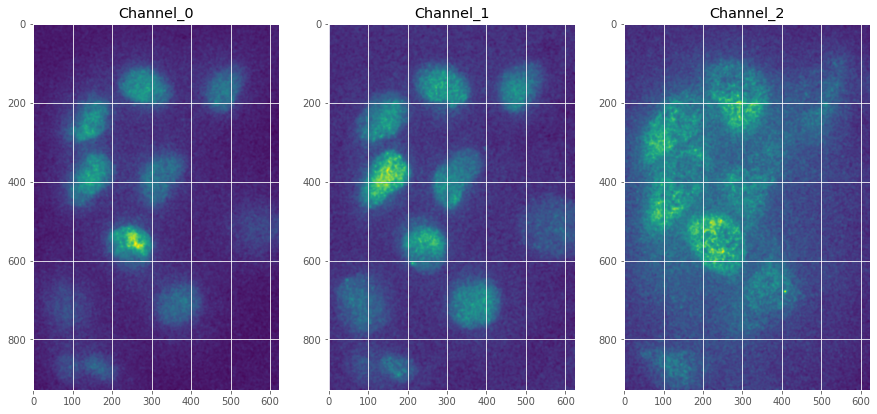

CELL SEGMENTATION


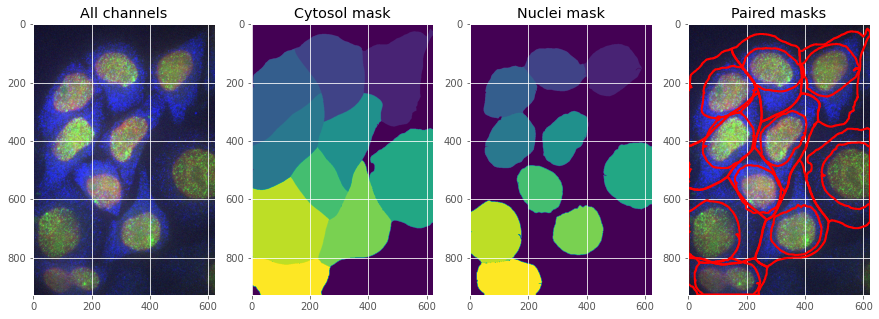

SPOT DETECTION
Spot Detection for Channel : 1
sigma_value (z,y,x) = (0.7, 1.7475728155339805, 1.7475728155339805)
Int threshold used for the detection of spots:  152.0


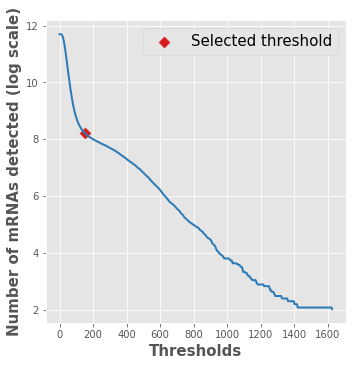

Z-Slice:  11


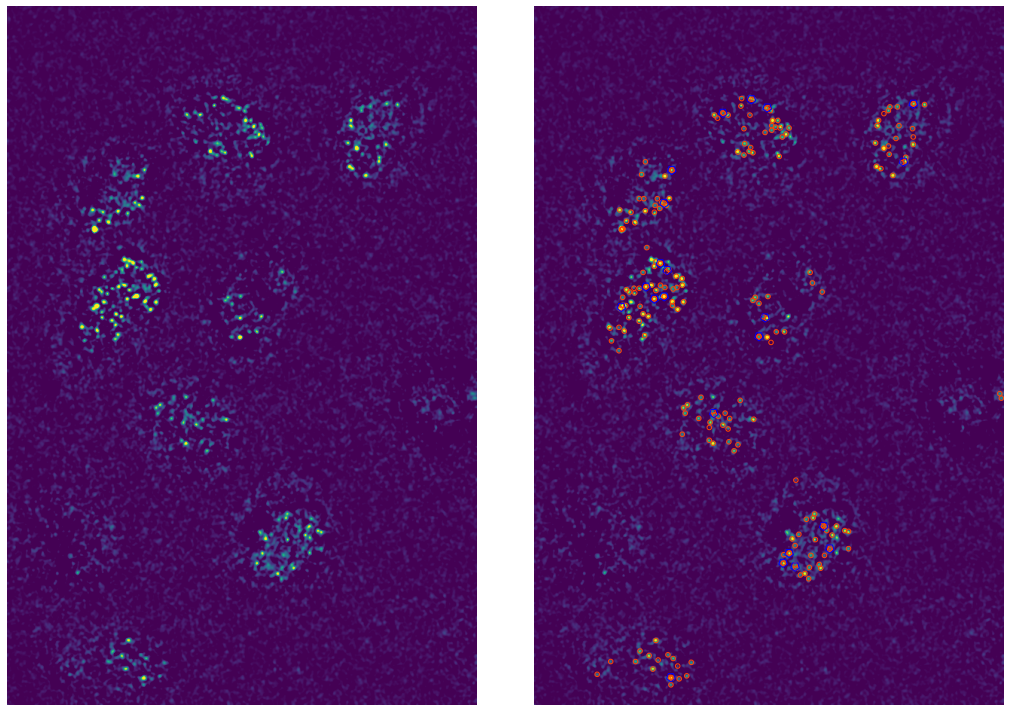

 ############### 
       IMAGE : 1
 ############### 
 
ORIGINAL IMAGE
ROI002_XY1620755646_Z00_T0_merged.tif
(23, 928, 624, 3)


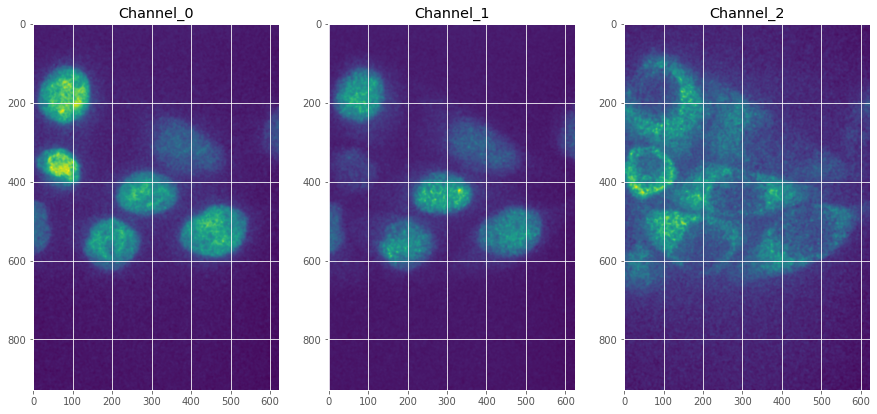

CELL SEGMENTATION


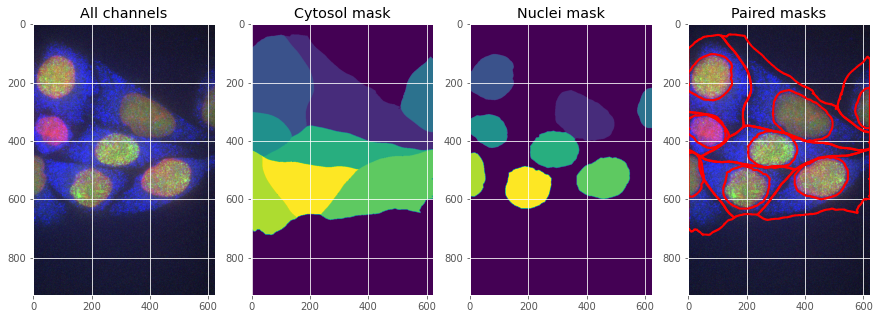

SPOT DETECTION
Spot Detection for Channel : 1
sigma_value (z,y,x) = (0.7, 1.7475728155339805, 1.7475728155339805)
Int threshold used for the detection of spots:  130.0


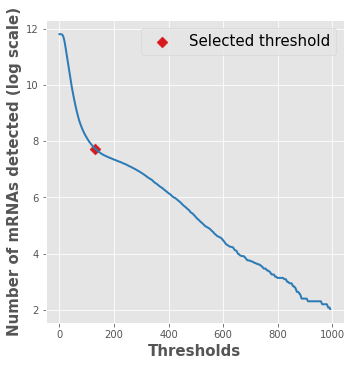

Z-Slice:  11


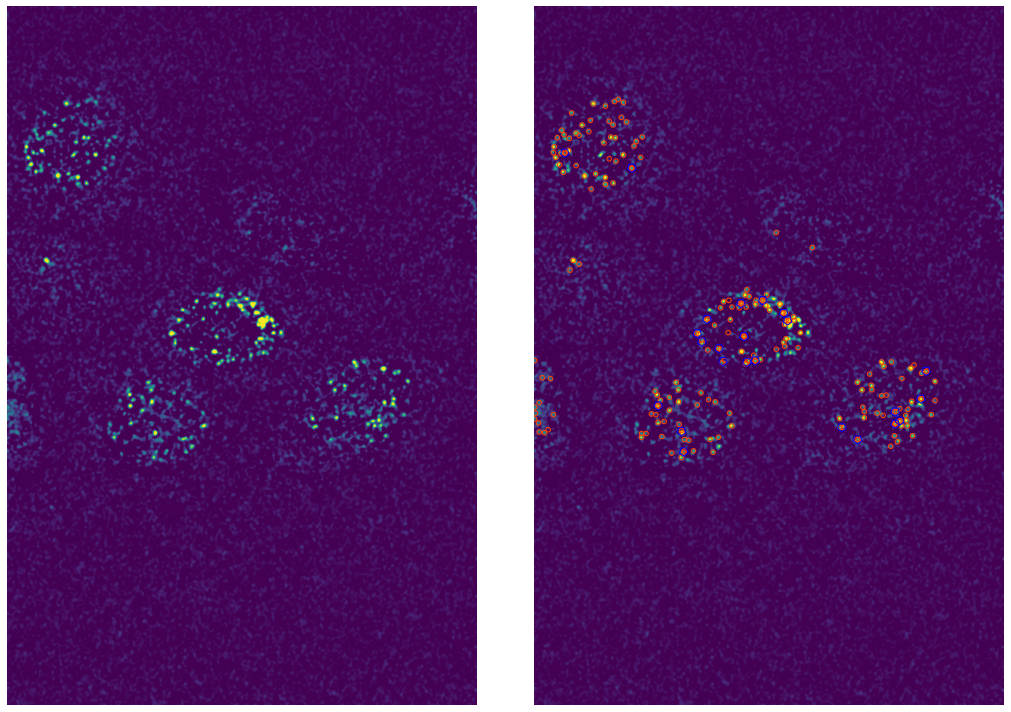

In [9]:
dataframe_FISH,list_masks_complete_cells,list_masks_nuclei,list_masks_cytosol_no_nuclei = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  list_voxels=list_voxels, list_psfs=list_psfs, show_plots=show_plots, file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection,use_brute_force=True  ).run()

## Extracting data from the dataframe

----

In [10]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.tail()

image_id  cell_id  spot_id  nucleus_y  nucleus_x  nuc_area_px  \
6269         1       17      455        559        197        17838   
6270         1       17      456        559        197        17838   
6271         1       17      457        559        197        17838   
6272         1       17      458        559        197        17838   
6273         1       17      459        559        197        17838   

      cyto_area_px  cell_area_px   z    y    x  is_nuc  is_cluster  \
6269         20861         17838  16  538  179       1           0   
6270         20861         17838  17  546  198       1           0   
6271         20861         17838  16  554  198       1           0   
6272         20861         17838  17  541  204       1           0   
6273         20861         17838   5  505  248       0           0   

      cluster_size  spot_type  is_cell_fragmented  
6269             0          0                   0  
6270             0          0                   0  
6271             0          0                   0  
6272             0          0                   0  
6273             0          0                   0

In [11]:
# Number of cells
spot_type_selected = 0
number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]
# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=4) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1)  ].cluster_size.values
# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

18


## Plotting

----

## Brian's Sand Box

In [12]:
# get list of file names
list_images, path_files, list_files_names, number_images = fa.ReadImages(local_data_dir).read()

In [13]:
import skimage # Library for image manipulation
from skimage.io import imread # sublibrary from skimage
# load a specific image into memory
iImage = 0
img = imread(path_files[iImage])

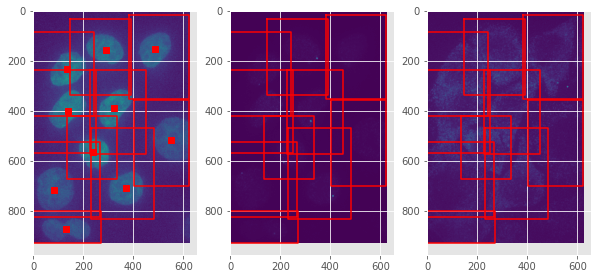

In [14]:
# Take max projection and plot result.
maxProjImg = np.max(img,axis=0)
fig, ax = plt.subplots(1,3, figsize=(10, 10))
inds = [0,1,2]
for i in range(3):
    ax[i].imshow(maxProjImg[:,:,inds[i]]) 

# Add Marker at center of the nucleus
NCells = np.max(list_masks_complete_cells[iImage])
for i in range(NCells):
    dataThisCell = dataframe_FISH[dataframe_FISH.cell_id==i]
    xyNuc = np.asarray([dataThisCell.nucleus_y,dataThisCell.nucleus_x])
    ax[0].plot(xyNuc[1,0],xyNuc[0,0],'rs')
    
# Add Square around each cell with bounds defiend by the determined masks
    selectedCell = (list_masks_complete_cells[iImage]==i+1)
    I = np.max(selectedCell,axis=0)==1
    J = np.max(selectedCell,axis=1)==1
    imin = list(I).index(True)
    imax = I.shape[0]-list(I[::-1]).index(True)
    jmin = list(J).index(True)
    jmax = J.shape[0]-list(J[::-1]).index(True)
    for j in range(3):
        ax[j].plot([imin,imax,imax,imin,imin],[jmin,jmin,jmax,jmax,jmin],'r')
  

In [15]:
dataframe_FISH.head()

image_id  cell_id  spot_id  nucleus_y  nucleus_x  nuc_area_px  \
0         0        0        0        154        485        24810   
1         0        0        1        154        485        24810   
2         0        0        2        154        485        24810   
3         0        0        3        154        485        24810   
4         0        0        4        154        485        24810   

   cyto_area_px  cell_area_px  z    y    x  is_nuc  is_cluster  cluster_size  \
0         26954         24810  3  157  450       1           1             2   
1         26954         24810  4  116  450       1           1             3   
2         26954         24810  4  117  481       1           1             2   
3         26954         24810  4  152  459       1           1             2   
4         26954         24810  5  209  467       1           1             2   

   spot_type  is_cell_fragmented  
0          0                   0  
1          0                   0  
2          0                   0  
3          0                   0  
4          0                   0

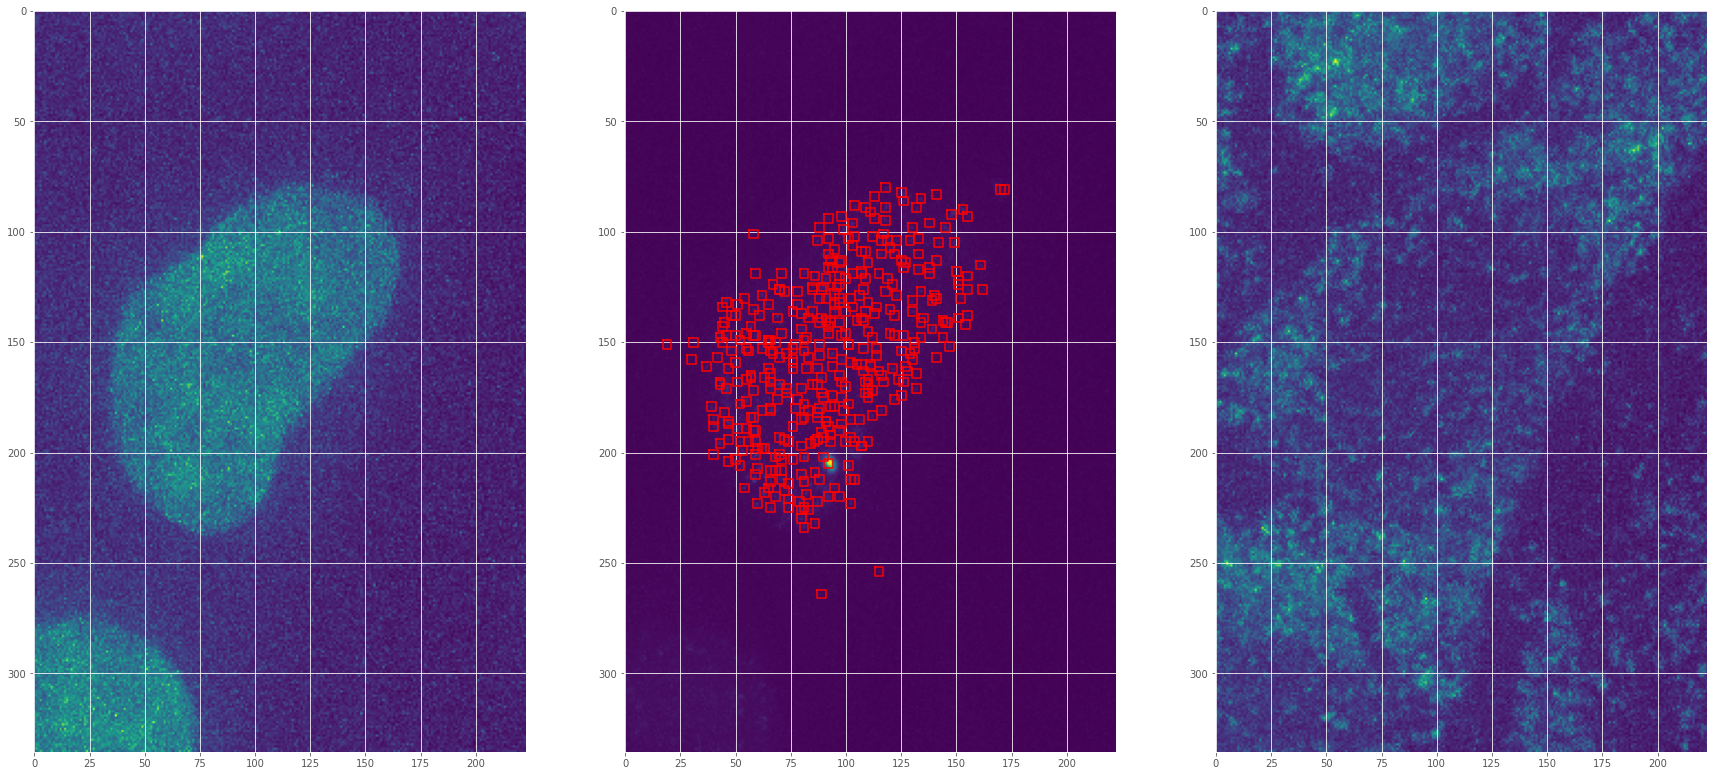

In [16]:
fig, ax = plt.subplots(1,3, figsize=(30, 30))
iCell = 4

# Select the cell mask - note that these were numbered starting at 1 (not 0)
selectedCell = (list_masks_complete_cells[iImage]==iCell+1)

# Zoom in to show crop of specific cell.
I = np.max(selectedCell,axis=0)==1
J = np.max(selectedCell,axis=1)==1
imin = list(I).index(True)
imax = I.shape[0]-list(I[::-1]).index(True)
jmin = list(J).index(True)
jmax = J.shape[0]-list(J[::-1]).index(True)

for i in range(3):
    ax[i].imshow(maxProjImg[jmin:jmax,imin:imax,inds[i]])
    
# Add marker in middle of nucleus (to make sure we are looking at the right cell)
dataThisCell = dataframe_FISH[dataframe_FISH.cell_id==iCell]
xyNuc = np.asarray([dataThisCell.nucleus_y,dataThisCell.nucleus_x])

def addSquares(xySpot,ax,imin,jmin,lenSquare=4.,spec='r'):
  for i in range(xySpot.shape[1]):
    xvals = xySpot[0,i] + [-lenSquare,lenSquare,lenSquare,-lenSquare,-lenSquare] - imin
    yvals = xySpot[1,i] + [-lenSquare,-lenSquare,lenSquare,lenSquare,-lenSquare] - jmin
    ax.plot(xvals,yvals,spec)
    
xyzSpot = np.asarray([dataThisCell.x,dataThisCell.y,dataThisCell.z])
for i in channels_with_FISH:
    addSquares(xyzSpot,ax[i],imin,jmin,lenSquare=2)

In [17]:
# Spot intensity estimation -- 
import seaborn as sns
from skimage.filters import difference_of_gaussians

# Apply difference of Gaussian Filter (similar to the Laplacian Of Gaussian)
img_diff_gaussians = np.zeros(img.shape)
for i in range(3):
    for zplane in range(img.shape[0]):
        tmp = difference_of_gaussians(img[zplane,:,:,i],low_sigma=psf_yx/voxel_size_yx)
        img_diff_gaussians[zplane,:,:,i] = tmp

        
# Calculate the intensity of spots
intens = np.zeros([xyzSpot.shape[1],1])
for j in [len(channels_with_FISH)-1]:
    for i in range(xyzSpot.shape[1]):
        try:
            wind = 1 # 3 by 3
            crp = img_diff_gaussians[xyzSpot[2,i],
                                     xyzSpot[1,i]-wind:xyzSpot[1,i]+wind+1,
                                     xyzSpot[0,i]-wind:xyzSpot[0,i]+wind+1,
                                     channels_with_FISH[j]]
            intens[i,j] = np.sum(crp)
        except:
            wind = [0] # 1 by 1
            crp = img_diff_gaussians[xyzSpot[2,i],
                                     xyzSpot[1,i]-wind:xyzSpot[1,i]+wind+1,
                                     xyzSpot[0,i]-wind:xyzSpot[0,i]+wind+1,
                                     channels_with_FISH[j]]
            crp = img_diff_gaussians[xyzSpot[2,i]+wind,xyzSpot[1,i]+wind,xyzSpot[0,i]+wind,channels_with_FISH[j]]
            intens[i,j] = np.sum(crp)               

# Make histogram of detected spot intensities.
# fig, ax = plt.subplots(1,1)
# sns.histplot(intens[:,0], ax=ax, stat="density", label="Distribution of Spot Intensities")
# ax.set_xlabel("Spot intensity")
# ax.set_ylabel("Number of spots")

In [19]:
# Widget to choose different z-planes and examine the spot detection results for different thresholds
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from skimage.filters import difference_of_gaussians

def fLow(LowThresh=0.1,HighThresh=0.9,zplane=7,showNearby=False):
    dataThisCell = dataframe_FISH[dataframe_FISH.cell_id==iCell]    
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.imshow(img_diff_gaussians[zplane,jmin:jmax,imin:imax,1])  
    
    minT = np.min(intens)+LowThresh*(np.max(intens)-np.min(intens))
    maxT = np.min(intens)+HighThresh*(np.max(intens)-np.min(intens))
    LOG = (intens>=minT)&(intens<=maxT)
    LOG0 = LOG[:,0]&(np.abs(xyzSpot[2,:]-zplane)==0)
    addSquares(xyzSpot[:,LOG0],ax,imin,jmin,lenSquare=2,spec='r')
    if showNearby:
        LOG1 = LOG[:,0]&(np.abs(xyzSpot[2,:]-zplane)==1)
        addSquares(xyzSpot[:,LOG1],ax,imin,jmin,lenSquare=2,spec='y')
        
w = interactive(fLow, LowThresh=(0,1,0.01), HighThresh=(0,1,0.01), zplane=(0,img.shape[0],1), showNearby=False)
display(w)

interactive(children=(FloatSlider(value=0.1, description='LowThresh', max=1.0, step=0.01), FloatSlider(value=0…

In [20]:
ind = np.flip(np.argsort(intens.flatten(),0))

def topSpots(Nspots=16,onlyNuclearClusters=False,showOriginalImage=False):
    dataThisCell = dataframe_FISH[dataframe_FISH.cell_id==iCell]
    if onlyNuclearClusters:
        Nspots=np.sum((dataThisCell.is_cluster==1)&(dataThisCell.is_nuc==1))
        print('Number of Transcription Sites = ' + str(Nspots))
    ni = np.int(np.ceil(np.sqrt(Nspots)))
    nj = np.int(np.floor(np.sqrt(Nspots)))
    fig, ax = plt.subplots(ni,nj, figsize=(10, 10))
    for i in range(ni):
        for j in range(nj):
            k = i*(ni-1)+j
            if k <= Nspots:
                if showOriginalImage:
                    ax[i,j].imshow(img[xyzSpot[2,ind[k]],xyzSpot[1,ind[k]]-4:xyzSpot[1,ind[k]]+4,xyzSpot[0,ind[k]]-4:xyzSpot[0,ind[k]]+4,1]) 
                else:
                    ax[i,j].imshow(img_diff_gaussians[xyzSpot[2,ind[k]],xyzSpot[1,ind[k]]-4:xyzSpot[1,ind[k]]+4,xyzSpot[0,ind[k]]-4:xyzSpot[0,ind[k]]+4,1],vmin = 0.,vmax = 0.005) 
                ax[i,j].set_title('I = '+ str(np.round((intens[ind[k],0]),4)))

w = interactive(topSpots, Nspots=(9,81,1),onlyNuclearClusters=False,showOriginalImage=False);
display(w)

interactive(children=(IntSlider(value=16, description='Nspots', max=81, min=9), Checkbox(value=False, descript…